In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/My Drive/phone_finder_problem/find_phone_task_4.zip' -d '/content/drive/My Drive/phone_finder_problem/'

In [ ]:
os.chdir('/content/drive/My Drive/phone_finder_problem')
!pwd
!ls

In [ ]:
!mv "/content/drive/My Drive/phone_finder_problem/find_phone/labels.txt" "/content/drive/My Drive/phone_finder_problem/"

In [24]:
#the code starts from here
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tqdm
import os
import re

(326, 490, 3)


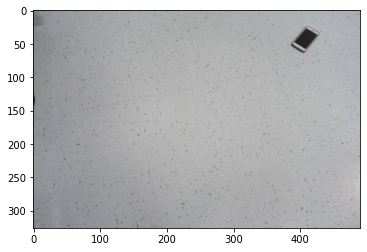

In [26]:
import os.path
file="/find_phone/0.jpg"
path=os.getcwd()+file
im = cv2.imread(path)
plt.imshow(im)
h, w, c = im.shape
print(im.shape)

In [27]:
# sorting the labels 
#first adding the labels.txt data into an array
f = open('labels.txt', 'r') 
array = []
for line in f.read().split('\n'):
  if line !='':
    array.append(line.split())
f.close()

#chaning array elemets forrmat to int and flaot an removing .jpg in the first column of data
rows = len(array)
columns=len(array[0])
for i in range(0,rows):
    array[i][0]=int(re.search(r'\d+', array[i][0]).group())
    array[i][1]=float(array[i][1])
    array[i][2]=float(array[i][2])


In [28]:
#Convert a NumPy Array to Pandas Dataframe
nparray = np.array(array)
df=pd.DataFrame(nparray, columns=['img_Index','x','y'])
#now sorting the data based on the img_Index value
labels_df=df.sort_values(by=['img_Index'])
labels_df.reset_index(inplace=True)# set a new ordered indices to the label data
labels_df=labels_df.drop(columns=['index'])

129
129


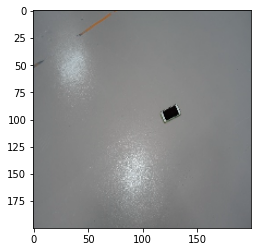

In [29]:
IMAGE_SIZE=200;
# here we add all the images into training_data list so we can make a dataframe with their equivalent label later 
training_data=[]
def train_image_data(): 
    for i in range(144):
        try:
            im = cv2.imread(os.getcwd()+'/find_phone/{0}.jpg'.format(i)) #using these commands we add all the images into trading_data by order 
            #img_array=cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
            im = cv2.resize(im,(IMAGE_SIZE,IMAGE_SIZE))
            training_data.append(im)
        except Exception as e:
           pass
train_image_data()

print(len(training_data))
#as it can be seen some of the image numbers are missing, using the following command we remove the None elements and at the same time keeping the order of images to make sure labels will be assigned to each image in a correct way
training_data=[x for x in training_data if x is not None]
print(len(training_data))
plt.imshow(training_data[128])# to check and see if the last image in traning_data is the same the last image in the folder

In [32]:
#now in order to solve the data scarcity problem a little bit, we flip the image to the left/right and top/bottom make the data size 2 times higher 129*3 as a total
Data_Size=3*len(training_data)
new_labels_array = []
extended_training_data=[]

for i in range(len(training_data)):
    extended_training_data.append(training_data[i])
    new_labels_array.append([labels_df['x'][i],labels_df['y'][i]])

    # FLIP_LEFT_RIGHT
    im=training_data[i]
    out = np.fliplr(im)    
    extended_training_data.append(out)
    new_labels_array.append([1-labels_df['x'][i],labels_df['y'][i]])

     # FLIP_TOP_BOTTOM
    im=training_data[i]
    out = np.flipud(im)
    extended_training_data.append(out)
    new_labels_array.append([labels_df['x'][i],1-labels_df['y'][i]])

#Convert a NumPy Array to Pandas Dataframe
extended_labels_df=pd.DataFrame(new_labels_array, columns=['x','y'])
    

In [ ]:
extended_labels_df

In [34]:
#now that we have all the images and their labels, it's time to put all of them into a new dataframe and use it for training or CNN network-regression problem
def create_training_Data():
  l = Data_Size;
  X_train = np.zeros(shape=[l,IMAGE_SIZE, IMAGE_SIZE,c]);
  Y_train = np.zeros(shape = [l,2]);
  for i in range(l):
      Y_train[i,0]= extended_labels_df['x'][i]; #x coordinate
      Y_train[i,1] = extended_labels_df['y'][i]; #y coordinate
      X_train[i,:,:,:]=extended_training_data[i]
  return {'X_Train' : X_train, 'Y_Train': Y_train};
final_training_data= create_training_Data()

[0.851  0.7331]


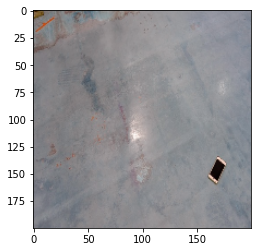

In [37]:
#test to see if the label data are assigned accurately
plt.imshow(final_training_data['X_Train'][195].astype('uint8'))#uint8 for displaying 3 channels
print((final_training_data['Y_Train'][195]))

In [38]:
import tensorflow;
from tensorflow.keras import layers;
from tensorflow.keras import Model;

In [39]:
img_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, c))
x = layers.Conv2D(5, 2, activation='tanh', strides = 1, padding = 'same')(img_input)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(10, 2, activation='tanh', strides = 2)(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(20, 2, activation='tanh', strides = 2)(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(2, 5, activation='tanh', strides = 2)(x)
output = layers.Flatten()(x)
model = Model(img_input, output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 200, 5)       65        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 5)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 10)        210       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 20)        820       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 20)          0     

In [40]:
#as this problem wants x and y coordinates which are continious values, we are facing a regression problem, so loss='mean_squared_error' is a better option here to be used
model.compile(loss='mean_squared_error',optimizer= 'adam', metrics=['mse']);

In [41]:
model.fit(final_training_data["X_Train"],final_training_data["Y_Train"], epochs = 8,verbose=1)

Epoch 1/8
13/13 [==============================] - 5s 331ms/step - loss: 0.0896 - mse: 0.0896
Epoch 2/8
13/13 [==============================] - 4s 327ms/step - loss: 0.0649 - mse: 0.0649
Epoch 3/8
13/13 [==============================] - 4s 337ms/step - loss: 0.0672 - mse: 0.0672
Epoch 4/8
13/13 [==============================] - 5s 350ms/step - loss: 0.0573 - mse: 0.0573
Epoch 5/8
13/13 [==============================] - 4s 342ms/step - loss: 0.0614 - mse: 0.0614
Epoch 6/8
13/13 [==============================] - 4s 337ms/step - loss: 0.0532 - mse: 0.0532
Epoch 7/8
13/13 [==============================] - 4s 336ms/step - loss: 0.0523 - mse: 0.0523
Epoch 8/8
13/13 [==============================] - 4s 321ms/step - loss: 0.0527 - mse: 0.0527


[[0.46855316 0.5237958 ]]
[0.202  0.4264]


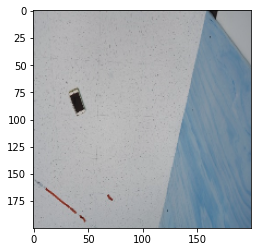

In [47]:
print(model.predict(final_training_data['X_Train'][59].reshape(1,IMAGE_SIZE, IMAGE_SIZE,c)))
print(final_training_data['Y_Train'][59])
plt.imshow(final_training_data['X_Train'][59].astype('uint8'))

In [52]:
#here you can see my second solution for this problem, Transfer Learning
#as we saw the above approach wasn't very successful which can be related to the small amount of data that we had to train the model
# as a result, in here we examine transfer learning
#import tensorflow as tf
#from keras import callbacks
from keras import optimizers
#from keras.engine import Model
#from keras.layers import Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.applications import VGG16
#from keras.datasets import cifar10
#from keras.utils import to_categorical
#import numpy as np
# We build the base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE,IMAGE_SIZE,c))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [53]:
# We freeze every layer in our base model so that they do not train, we want that our feature extractor stays as before --> transfer learning
for layer in base_model.layers: 
  layer.trainable = False
  print('Layer ' + layer.name + ' frozen.')
# We take the last layer of our the model and add it to our classifier
last = base_model.layers[-1].output
x = layers.Conv2D(5, 2, activation='tanh', strides = 1, padding = 'same')(last)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(2, 2, activation='tanh', strides = 2)(x)
x = layers.Flatten()(x)
model = Model(base_model.input, x)
model.summary()

Layer input_3 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Layer block5_conv1 frozen.
Layer block5_conv2 frozen.
Layer block5_conv3 frozen.
Layer block5_pool frozen.
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
__________________

In [54]:
model.compile(loss='mean_squared_error',optimizer=Adam(lr=0.01), metrics=['mse']);

In [55]:
model.fit(final_training_data["X_Train"],final_training_data["Y_Train"], epochs = 8,verbose=1)

Epoch 1/8
13/13 [==============================] - 154s 12s/step - loss: 0.4115 - mse: 0.4115
Epoch 2/8
13/13 [==============================] - 153s 12s/step - loss: 0.1292 - mse: 0.1292
Epoch 3/8
13/13 [==============================] - 153s 12s/step - loss: 0.0897 - mse: 0.0897
Epoch 4/8
13/13 [==============================] - 152s 12s/step - loss: 0.0762 - mse: 0.0762
Epoch 5/8
13/13 [==============================] - 153s 12s/step - loss: 0.0673 - mse: 0.0673
Epoch 6/8
13/13 [==============================] - 153s 12s/step - loss: 0.0579 - mse: 0.0579
Epoch 7/8
13/13 [==============================] - 156s 12s/step - loss: 0.0562 - mse: 0.0562
Epoch 8/8
13/13 [==============================] - 154s 12s/step - loss: 0.0549 - mse: 0.0549


[[0.90928966 0.32693672]]
[0.8306 0.135 ]


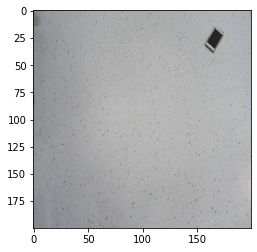

In [59]:
print(model.predict(final_training_data['X_Train'][0].reshape(1,IMAGE_SIZE, IMAGE_SIZE,c)))
print(final_training_data['Y_Train'][0])
plt.imshow(final_training_data['X_Train'][0].astype('uint8'))